In [1]:
!pip3 install kymatio
!pip3 install scikit-cuda
!pip install torch==1.7.0 torchvision==0.8.0
import numpy as np 
import os,csv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import random
from torchvision import transforms
import torch.optim
from PIL import Image
from kymatio.torch import Scattering2D

     |████████████████████████████████| 102kB 4.2MB/s 
     |████████████████████████████████| 122kB 10.0MB/s 
     |████████████████████████████████| 1.6MB 9.1MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp37-cp37m-linux_x86_64.whl size=620850 sha256=6ebc85869e783e1b448983e46c8c8f34c8379b33366f0477f26988cf4d3a283a
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2021.2.2-py2.py3-none-any.whl size=60166 sha256=4f5edb512a42509968d0f0a7ff6a5c7701d877e27c739748f951f08e00a35583
  Stored in directory: /root/.cache/pip/wheels/a2/71/a4/2c1a223ad52e28a878053c37dc9d59a58a749eaa920ef00231
Successfully built pycuda pytools
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 11.8MB 213kB/s 
ERROR: torchtext 0.9.1 has requirement torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [4]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

# scattering = Scattering2D(J=2, shape=(544, 800), backend='torch_skcuda')
scattering = Scattering2D(J=2, shape=(544, 800))
scattering.cuda()

def scatter_img(img):
  return scattering(img)

In [5]:
x = torch.randn(1,544,800)
b = scattering(x.cuda()).squeeze(dim=0)
print(b.shape)

torch.Size([81, 136, 200])


/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:148: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  fft = FFT(lambda x: torch.fft(x, 2, normalized=False),
/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:150: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  lambda x: torch.irfft(x, 2, normalized=False, onesided=False),
/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:149: UserWarning: The function tor

In [6]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        scattering = scatter_img(image).squeeze(dim=0).detach()
        sample = {'image': image, 'mask': mask, 'scatter':scattering}
        return sample

In [7]:
base_folder = '/content/drive/MyDrive/hc18/training_set'
image_folder = base_folder
mask_folder = base_folder

In [9]:
traindir="/content/drive/MyDrive/hc18/training_set/"
i=0
trainname=[]
with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [10]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [11]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [12]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
# class Unet(nn.Module):
#     def __init__(self):
#         super(Unet, self).__init__()
       
#         self.encoder_1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),   
#             nn.BatchNorm2d(64), nn.ReLU(True),
#             nn.Conv2d(64, 64, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2), nn.ReLU(True)
#         )
#         self.encoder_2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),   
#             nn.BatchNorm2d(128), nn.ReLU(True),
#             nn.Conv2d(128, 128, 3, padding=1),
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_3 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),   nn.ReLU(True),
#             nn.Conv2d(256, 256, 3, padding=1),  
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_4 = nn.Sequential(
#             nn.Conv2d(256, 512, 3, padding=1),   
#             nn.BatchNorm2d(512),  nn.ReLU(True),
#             nn.Conv2d(512, 512, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_5 = nn.Sequential(
#             nn.Conv2d(512, 1024, 3, padding=1),   
#             nn.BatchNorm2d(1024),   nn.ReLU(True),
#             nn.Conv2d(1024, 1024, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.conv_merge_1= nn.Sequential(
#             nn.Conv2d(1024, 1024, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_2= nn.Sequential(
#             nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_3= nn.Sequential(
#             nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_4= nn.Sequential(
#             nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_5=nn.Sequential(
#             nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_1 = nn.Sequential(
#             nn.ConvTranspose2d(1024, 512, 2, stride=2), 
#             nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_2 = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 2, stride=2), 
#             nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_3 = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, 2, stride=2), 
#             nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_4 = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 2, stride=2), 
#             nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_5 = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 2, stride=2), 
#             nn.Conv2d(32, 1, 3, padding=1),   nn.ReLU(True),
#         )

#     def forward(self, x):
#         x1 = self.encoder_1(x)
#         x2 = self.encoder_2(x1)
#         x3 = self.encoder_3(x2)
#         x4 = self.encoder_4(x3)
#         x5 = self.encoder_5(x4)
#         # b = self.scatter(y)
#         # c = torch.cat([x5,b],dim=1)
#         # print("Model", x5.shape, b.shape, c.shape)
#         d = self.conv_merge_1(x5)
#         y1 = self.decoder_1(d)
#         f = torch.cat([x4,y1],dim=1)
#         g = self.conv_merge_2(f)
#         y2 = self.decoder_2(g)
#         h = torch.cat([x3,y2],dim=1)
#         i = self.conv_merge_3(h)
#         y3 = self.decoder_3(i)
#         j = torch.cat([x2,y3],dim=1)
#         k = self.conv_merge_4(j)
#         y4 = self.decoder_4(k)
#         l = torch.cat([x1,y4],dim=1)
#         m = self.conv_merge_5(l)
#         n = self.decoder_5(m)
#         return n

# Unet_model = Unet().to(device=device)
# summary(Unet_model, (1, 544, 800))

In [104]:
class Dunet(nn.Module):
    def __init__(self):
        super(Dunet, self).__init__()
       
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),   
            nn.MaxPool2d(2, stride=2), nn.ReLU(True)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),   nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),  
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),   
            nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),   
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.scatter = nn.Sequential(
            nn.Conv2d(81, 256, 3, padding=1),   
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),   nn.ReLU(True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),   nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),    nn.ReLU(True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.conv_merge_1= nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_2= nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_3= nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_4= nn.Sequential(
            nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_5=nn.Sequential(
            nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2), 
            nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), 
            nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), 
            nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), 
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.Conv2d(32, 1, 3, padding=1),   nn.Sigmoid(),
        )

    def forward(self, x, y):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x4 = self.encoder_4(x3)
        x5 = self.encoder_5(x4)
        b = self.scatter(y)
        c = torch.cat([x5,b],dim=1)
        # print("Model", x5.shape, b.shape, c.shape)
        d = self.conv_merge_1(c)
        y1 = self.decoder_1(d)
        f = torch.cat([x4,y1],dim=1)
        g = self.conv_merge_2(f)
        y2 = self.decoder_2(g)
        h = torch.cat([x3,y2],dim=1)
        i = self.conv_merge_3(h)
        y3 = self.decoder_3(i)
        j = torch.cat([x2,y3],dim=1)
        k = self.conv_merge_4(j)
        y4 = self.decoder_4(k)
        l = torch.cat([x1,y4],dim=1)
        m = self.conv_merge_5(l)
        n = self.decoder_5(m)
        return n

model = Dunet().to(device=device)
model.load_state_dict(torch.load('/content/drive/MyDrive/hc18/saved_model4'))

# summary(model, [(1, 544, 800),(81,136,200)])

<All keys matched successfully>

In [47]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        

    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0

print('Finished Training')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/hc18/saved_model')

In [29]:
import cv2

def show_image(image,show=True,noaxis=False):
	plt.imshow(image)
	if noaxis:
		plt.axis('off')
	if show:
		plt.show()

def image_grid(images, titles=None, subp=None, noaxis=False):
	if subp==None:
		subp = 10+len(images)
	if type(subp)==int:
		subp = [int(i) for i in str(subp)]
	rows, cols = subp
	for i, image in enumerate(images):
		plt.subplot(rows,cols,i+1)
		if titles is not None:
			plt.title(titles[i])
		show_image(image,False,noaxis)
	plt.show()



In [39]:
class TestDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,self.files[idx])
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        scattering = scatter_img(image).squeeze(dim=0).detach()
        sample = {'image': image, 'mask': mask, 'scatter':scattering}
        return sample

In [31]:
image_folder='/content/drive/MyDrive/validation_set/img'
mask_folder='/content/drive/MyDrive/validation_set/labelcol'
mypath=image_folder
files=[f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
Test_Train_Dataset = TestDataset(image_folder,mask_folder,files,transform)
testLoader = DataLoader(Test_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

In [64]:
# evaluate model:
model.eval()
with torch.no_grad():
    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        print(i)
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        for j in range(images.shape[0]):        
            output = np.array(transforms.ToPILImage()(outputs[j]))
            # image_grid([output])
            cv2.imwrite("/content/drive/MyDrive/validation_set/output/"+str(i)+str(j)+".png",output)

# Restore training
model.train()
print('Finished Evaluation')

0
Mini - Batch  0 Loss 0.08089959621429443
1
Mini - Batch  1 Loss 0.11603236198425293
2
Mini - Batch  2 Loss 0.0932355523109436
3
Mini - Batch  3 Loss 0.0977022647857666
4
Mini - Batch  4 Loss 0.09855502843856812
5
Mini - Batch  5 Loss 0.09501487016677856
6
Mini - Batch  6 Loss 0.08556240797042847
7
Mini - Batch  7 Loss 0.05833989381790161
Finished Evaluation


Mini - Batch  0 Loss 0.025318145751953125
torch.Size([1, 544, 800])
Finished Evaluation


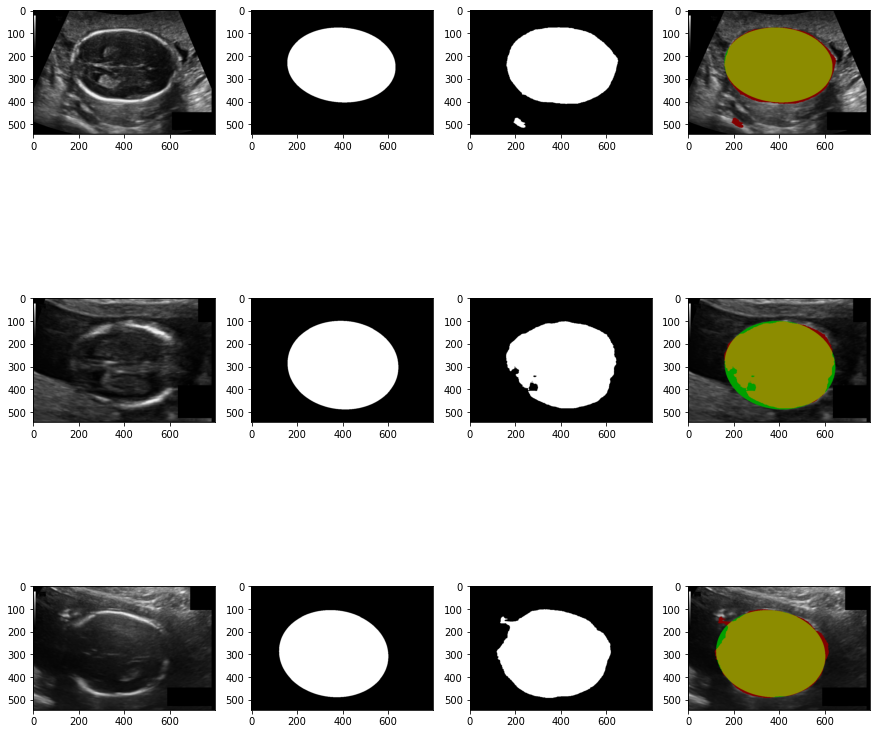

In [125]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 0
        image = transforms.ToPILImage()(images[i])
        mask = transforms.ToPILImage()(masks[i])
        output = transforms.ToPILImage()(outputs[i])
        output=np.array(output)
        output[output>75]=255
        output[output<=75]=0
        mask=np.array(mask)
        image=np.array(image)
        image=cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        imagecopy=image.copy()
        for k in range(output.shape[0]):
          for l in range(output.shape[1]):
            if(output[k][l]==255 and mask[k][l]==255):
              image[k][l][0]=140
              image[k][l][1]=140
              image[k][l][2]=0
            elif(mask[k][l]==255):
              image[k][l][0]=0
              image[k][l][1]=160
              image[k][l][2]=0
            elif(output[k][l]==255):
              image[k][l][0]=130
              image[k][l][1]=0
              image[k][l][2]=0
        plt.subplot(3,4,4*i+1)
        plt.imshow(imagecopy)
        plt.subplot(3,4,4*i+2)
        plt.imshow(mask,'gray')
        plt.subplot(3,4,4*i+3)
        plt.imshow(output,'gray')
        plt.subplot(3,4,4*i+4)
        plt.imshow(image,'gray')

        i = 1
        image = transforms.ToPILImage()(images[i])
        mask = transforms.ToPILImage()(masks[i])
        output = transforms.ToPILImage()(outputs[i])
        output=np.array(output)
        output[output>75]=255
        output[output<=75]=0
        mask=np.array(mask)
        image=np.array(image)
        image=cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        imagecopy=image.copy()
        for k in range(output.shape[0]):
          for l in range(output.shape[1]):
            if(output[k][l]==255 and mask[k][l]==255):
              image[k][l][0]=140
              image[k][l][1]=140
              image[k][l][2]=0
            elif(mask[k][l]==255):
              image[k][l][0]=0
              image[k][l][1]=160
              image[k][l][2]=0
            elif(output[k][l]==255):
              image[k][l][0]=130
              image[k][l][1]=0
              image[k][l][2]=0        
        plt.subplot(3,4,4*i+1)
        plt.imshow(imagecopy)
        plt.subplot(3,4,4*i+2)
        plt.imshow(mask,'gray')
        plt.subplot(3,4,4*i+3)
        plt.imshow(output,'gray')
        plt.subplot(3,4,4*i+4)
        plt.imshow(image,'gray')


        i = 2
        image = transforms.ToPILImage()(images[i])
        mask = transforms.ToPILImage()(masks[i])
        output = transforms.ToPILImage()(outputs[i])
        output=np.array(output)
        output[output>75]=255
        output[output<=75]=0
        mask=np.array(mask)
        image=np.array(image)
        image=cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        imagecopy=image.copy()
        for k in range(output.shape[0]):
          for l in range(output.shape[1]):
            if(output[k][l]==255 and mask[k][l]==255):
              image[k][l][0]=140
              image[k][l][1]=140
              image[k][l][2]=0
            elif(mask[k][l]==255):
              image[k][l][0]=0
              image[k][l][1]=160
              image[k][l][2]=0
            elif(output[k][l]==255):
              image[k][l][0]=130
              image[k][l][1]=0
              image[k][l][2]=0
        plt.subplot(3,4,4*i+2)
        plt.imshow(mask,'gray')
        plt.subplot(3,4,4*i+1)
        plt.imshow(imagecopy)
        plt.subplot(3,4,4*i+3)
        plt.imshow(output,'gray')
        plt.subplot(3,4,4*i+4)
        plt.imshow(image,'gray')
        break

# Restore training
# model.train()
print('Finished Evaluation')